# Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

### For classification visualization purpose ###
from utils import visualize_svm_model, visualize_knn_model

### Import machine learning algorithms ###
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

plt.style.use('ggplot') # change plot style

# Exploratory Data Analysis (EDA)

In [20]:
# Read and display first 5 columns
data = pd.read_csv('../datasets/heart.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [21]:
# Check for data types and any null values
# No missing values and this dataset only have float and int data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


## Correlation matrix

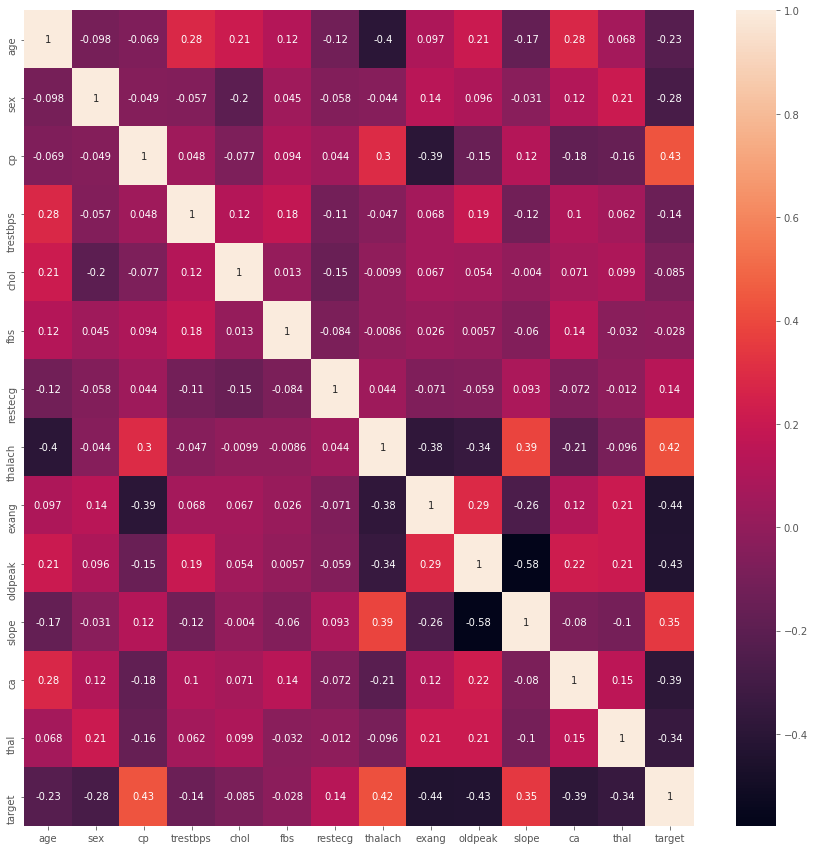

In [22]:
# Usually we are interested in the column/row of our target values
# We want to check what features correlate highly with the target so that we can choose features
# However, we really do not want to select very very correlated features

# 1. Resize matplotlib figure
fig, ax = plt.subplots(figsize=(15, 15))

# 2. Get the correlation matrix
corr_matrix = data.corr()

# 3. Plot the corr matrix with heatmap
sns.heatmap(corr_matrix, annot=True)

# 4. Show figure
plt.show()

### Attributes' distribution by class

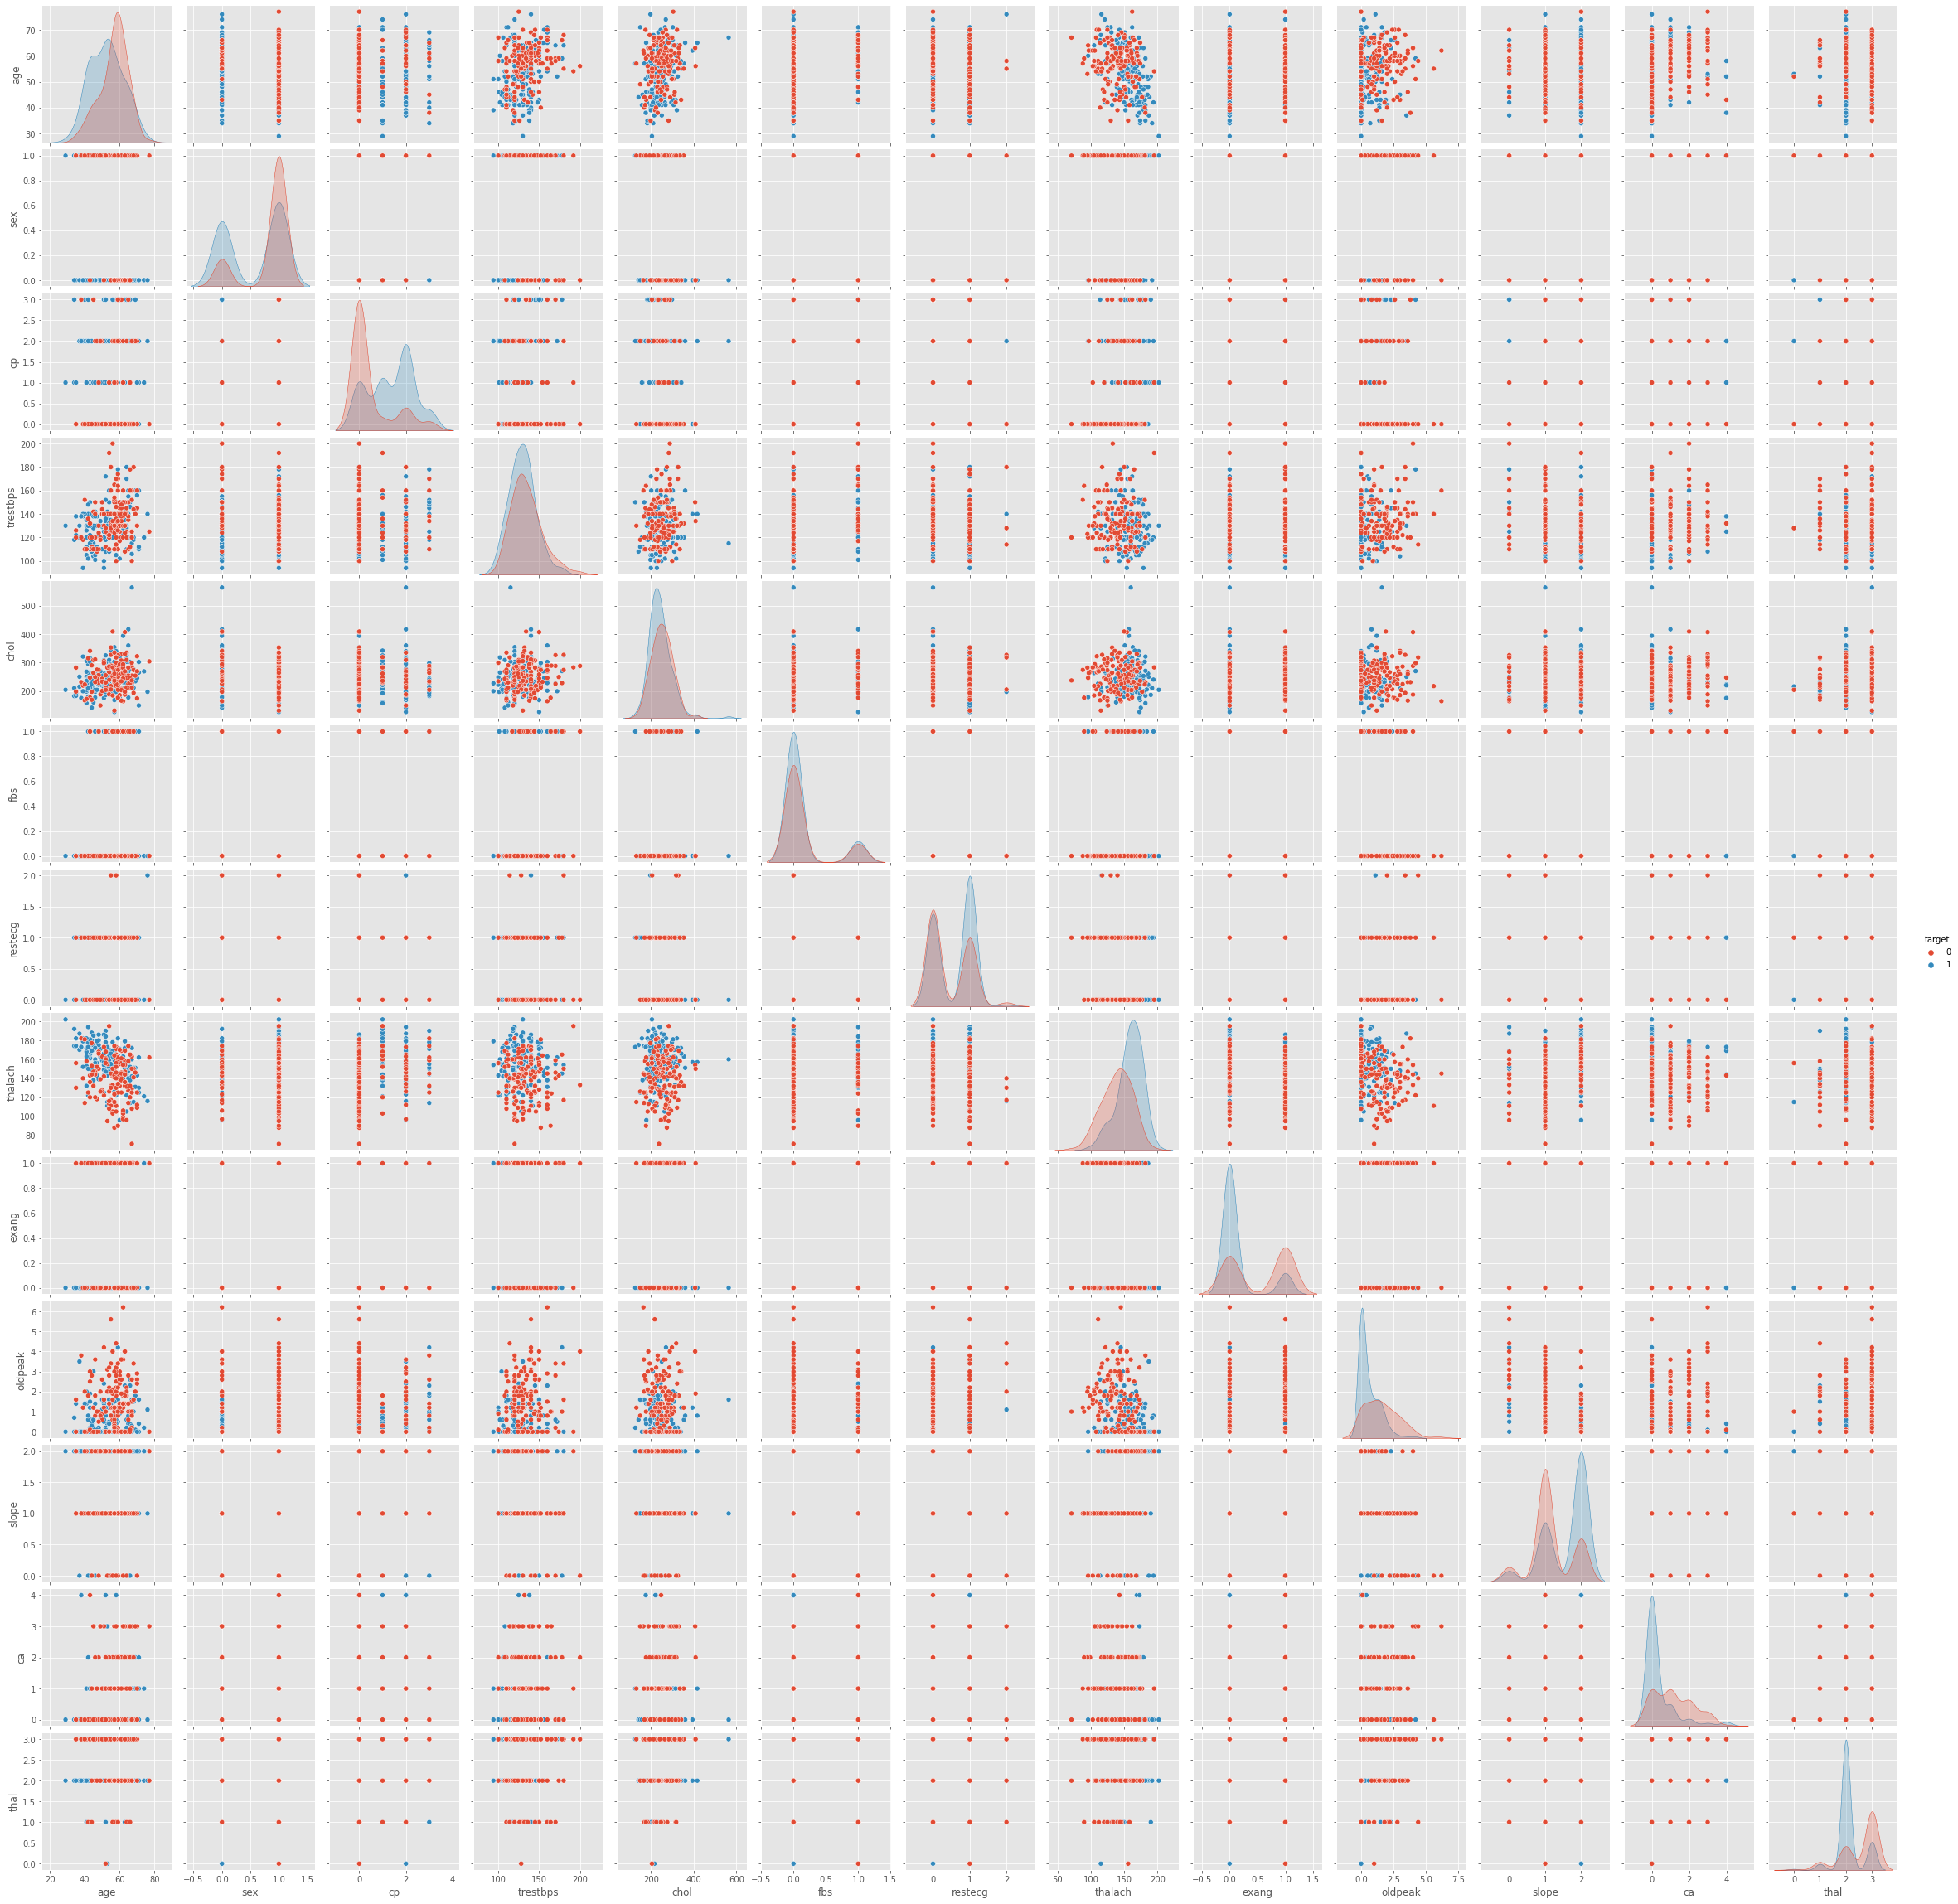

In [5]:
sns.pairplot(data=data, hue='target')
plt.show()

# Data cleaning and feature preprocessing

## 1. Handling missing data

In [6]:
# No missing data

## 2. Handling non-numeric data

In [7]:
# We have no non-numeric data

## 3. Feature scaling

In [23]:
# We still exclude our target and our categorical column
excluded = ['target']

# 1. Create the scaler
scaler = StandardScaler()

# 2. Loop through all columns and rescale them
for col in data.columns:
    if(col not in excluded):
        # 3. Replace the original values with rescaled values (change to vector form)
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
        
data.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0.952197,0.681005,1.973123,0.763956,-0.256334,2.394438,-1.005832,0.015443,-0.696631,1.087338,-2.274579,-0.714429,-2.148873,1
1,-1.915313,0.681005,1.002577,-0.092738,0.072199,-0.417635,0.898962,1.633471,-0.696631,2.122573,-2.274579,-0.714429,-0.512922,1
2,-1.474158,-1.468418,0.032031,-0.092738,-0.816773,-0.417635,-1.005832,0.977514,-0.696631,0.310912,0.976352,-0.714429,-0.512922,1


# Model training

## 1. Select best model with cross validation

### 1.1. Select features to train on
* How RFE works :
    - RFE stands for "Recursive Feature Elimination"
    - To work with RFE you will need a model (classification or regression) as a base estimator and a method to rank feature's importance (The default method is using coefficient of that feature).
    - Initially, the model will train with the full set of features. Then, the least important feature will be pruned from the features set. The model will re-train with one missing feature. The process continues until the desired number of features is reached.

In [24]:
features_col = list(data.columns) # Get all columns
features_col.remove('target') # Remove the target column from the set of columns
targets_col = 'target' 

features = data[features_col]
targets = data[targets_col]

In [25]:
# Previously in regression analysis and regression modelling session we did not go through feature selection but for this session
# this concept will be introduced. The motivation behind feature selection is that when a dataset is too large and there are lots
# of redundant features that cause the model to learn redundant insights, which causes overfitting in modelling. What we want to 
# do is just select the necessary features for model training

model = SVC(kernel='linear')
rfe = RFE(model, n_features_to_select=8)
fit = rfe.fit(features, targets)
print("Num Features : ", (fit.n_features_))
print("All features : ", features_col)
print("Selected Features : " , (fit.support_))
print("Feature Ranking : " , (fit.ranking_))

Num Features :  8
All features :  ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Selected Features :  [False  True  True  True False False False  True  True  True False  True
  True]
Feature Ranking :  [6 1 1 1 3 4 5 1 1 1 2 1 1]


In [26]:
# Get the selected features
selected_features = []

# Loop through all the features to see if they are selected 
for i in range(len(features_col)):
    if(fit.support_[i]): # If this feature is selected
        selected_features.append(features_col[i]) # Append to selected list
        
print(selected_features)

['sex', 'cp', 'trestbps', 'thalach', 'exang', 'oldpeak', 'ca', 'thal']


In [27]:
# Update the feature set 
features = data[selected_features]
features.head()

,sex,cp,trestbps,thalach,exang,oldpeak,ca,thal
0,0.681005,1.973123,0.763956,0.015443,-0.696631,1.087338,-0.714429,-2.148873
1,0.681005,1.002577,-0.092738,1.633471,-0.696631,2.122573,-0.714429,-0.512922
2,-1.468418,0.032031,-0.092738,0.977514,-0.696631,0.310912,-0.714429,-0.512922
3,0.681005,0.032031,-0.663867,1.239897,-0.696631,-0.206705,-0.714429,-0.512922
4,-1.468418,-0.938515,-0.663867,0.583939,1.435481,-0.379244,-0.714429,-0.512922


### 1.2. Select the best model to train

In [28]:
svm = SVC()
tree = RandomForestClassifier()
knn = KNeighborsClassifier()

splitter = StratifiedShuffleSplit(n_splits=10)

summary = {
    "svm" : [],
    "tree" : [],
    "knn" : []
}

for train_index, val_index in splitter.split(features, targets):
    X_train, X_val = features.loc[train_index], features.loc[val_index]
    Y_train, Y_val = targets.loc[train_index], targets.loc[val_index]
    
    # Fit all models
    svm.fit(X_train, Y_train)
    tree.fit(X_train, Y_train)
    knn.fit(X_train, Y_train)
    
    # Let all models make predictions on the validation dataset
    pred_svm = svm.predict(X_val)
    pred_tree = tree.predict(X_val)
    pred_knn = knn.predict(X_val)
    
    # Calculate the accuracy of each model on the validation set
    acc_svm = accuracy_score(Y_val, pred_svm)
    acc_tree = accuracy_score(Y_val, pred_tree)
    acc_knn = accuracy_score(Y_val, pred_knn)
    
    # Add these accuracies to the respective list
    summary['svm'].append(acc_svm)
    summary['tree'].append(acc_tree)
    summary['knn'].append(acc_knn)
    
# Print out the summary to decide the best model to pick
for model in summary.keys():
    acc = np.array(summary[model]).mean()
    print(f'Mean accuracy of model {model} is {acc}')

Mean accuracy of model svm is 0.8129032258064516
Mean accuracy of model tree is 0.8193548387096774
Mean accuracy of model knn is 0.7903225806451613


### 2. Hyperparams tuning for the best model

In [29]:
# Define the parameters
params = {
    "criterion" : ["entropy", "gini"],
    "max_depth" : [20, 25],
}

# Create a parameter grid and start fitting 
model = DecisionTreeClassifier()
gridcv = GridSearchCV(model, params, scoring='accuracy', cv=3, verbose=3)
gridcv.fit(features, targets)
print(gridcv.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END ...criterion=entropy, max_depth=20;, score=0.762 total time=   0.0s
[CV 2/3] END ...criterion=entropy, max_depth=20;, score=0.762 total time=   0.0s
[CV 3/3] END ...criterion=entropy, max_depth=20;, score=0.713 total time=   0.0s
[CV 1/3] END ...criterion=entropy, max_depth=25;, score=0.743 total time=   0.0s
[CV 2/3] END ...criterion=entropy, max_depth=25;, score=0.762 total time=   0.0s
[CV 3/3] END ...criterion=entropy, max_depth=25;, score=0.723 total time=   0.0s
[CV 1/3] END ......criterion=gini, max_depth=20;, score=0.812 total time=   0.0s
[CV 2/3] END ......criterion=gini, max_depth=20;, score=0.733 total time=   0.0s
[CV 3/3] END ......criterion=gini, max_depth=20;, score=0.703 total time=   0.0s
[CV 1/3] END ......criterion=gini, max_depth=25;, score=0.812 total time=   0.0s
[CV 2/3] END ......criterion=gini, max_depth=25;, score=0.703 total time=   0.0s
[CV 3/3] END ......criterion=gini, max_depth=25;,

### 3. Train the best model

In [30]:
from sklearn.decomposition import PCA

model = DecisionTreeClassifier(criterion='entropy', max_depth=25, min_samples_leaf=1, max_features='log2')
X_train, X_test, Y_train, Y_test = train_test_split(features, targets, test_size=0.2)

model.fit(X_train, Y_train)
model.predict(X_test)
prediction = model.predict(X_test)
acc = accuracy_score(prediction, Y_test)
print(acc)

0.819672131147541
